In [110]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Step 1: Load and Understand the Data

In [111]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [112]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [113]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [114]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Inspect the Data:

In [115]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [116]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Key Observations:
- user_id links both tables.
- Engagement logs daily usage.
- Need to identify users who meet the "adopted" definition.

## Step 2: Define “Adopted Users” from Engagement Data


We need to find all users who had 3 logins in any rolling 7-day window .

### Approach:
- Sort engagement by user_id and time_stamp.
- For each user, check if there’s any 7-day window with at least 3 unique login days.
- Create a new column indicating whether the user is adopted.

In [117]:
# Convert time_stamp to datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# Sort by user and date
engagement_sorted = engagement.sort_values(by=['user_id', 'time_stamp'])

# Function to detect adoption
def is_adopted(user_log):
    dates = user_log['time_stamp'].unique()
    for i in range(len(dates)):
        start_date = dates[i]
        end_date = start_date + datetime.timedelta(days=7)
        window_dates = dates[(dates >= start_date) & (dates <= end_date)]
        if len(window_dates) >= 3:
            return True
    return False

# Group by user and apply function
adopted_users = engagement_sorted.groupby('user_id').apply(is_adopted).reset_index(name='adopted')

#### Now you have a list of users labeled as adopted or not.

In [118]:
adopted_users.head()

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


## Step 3: Merge Adoption Label Back to User Table

In [119]:
users_adopted = users.merge(adopted_users, left_on='object_id', right_on='user_id', how='left')
users_adopted['adopted'] = users_adopted['adopted'].fillna(False)

#### Now your users_adopted DataFrame includes a binary label (True/False) for adoption.

## Step 4: Explore Features That Might Predict Adoption

### Now analyze which features are correlated with being an adopted user.

Suggested Features to Analyze:

In [120]:
features = pd.read_csv('table-5eb0ab5f-2117-40e2-984b-8e8c0aa99889-47.csv', index_col=0)
features

,Description,Possible Correlation
Feature,,
creation_source,How user joined,Some sources may lead to higher adoption
opted_in_to_mailing_list,Email opt-in,May correlate with product interest
enabled_for_marketing_drip,On marketing drip,Could affect retention
org_id,Organization ID,Belonging to certain orgs might influence adop...
invited_by_user_id,Was the user invited?,Invitations might drive early usage
last_session_creation_time,Unix timestamp of last login,Active users likely to adopt


### Analyzing Features for User Adoption

We will analyze the features in the `users_adopted` DataFrame to determine which ones might be correlated with user adoption. The features we will consider include:

- `creation_source`
- `last_session_creation_time`
- `opted_in_to_mailing_list`
- `enabled_for_marketing_drip`
- `org_id`
- `invited_by_user_id`

Let's start by examining the distribution of these features and their correlation with the `adopted` label.

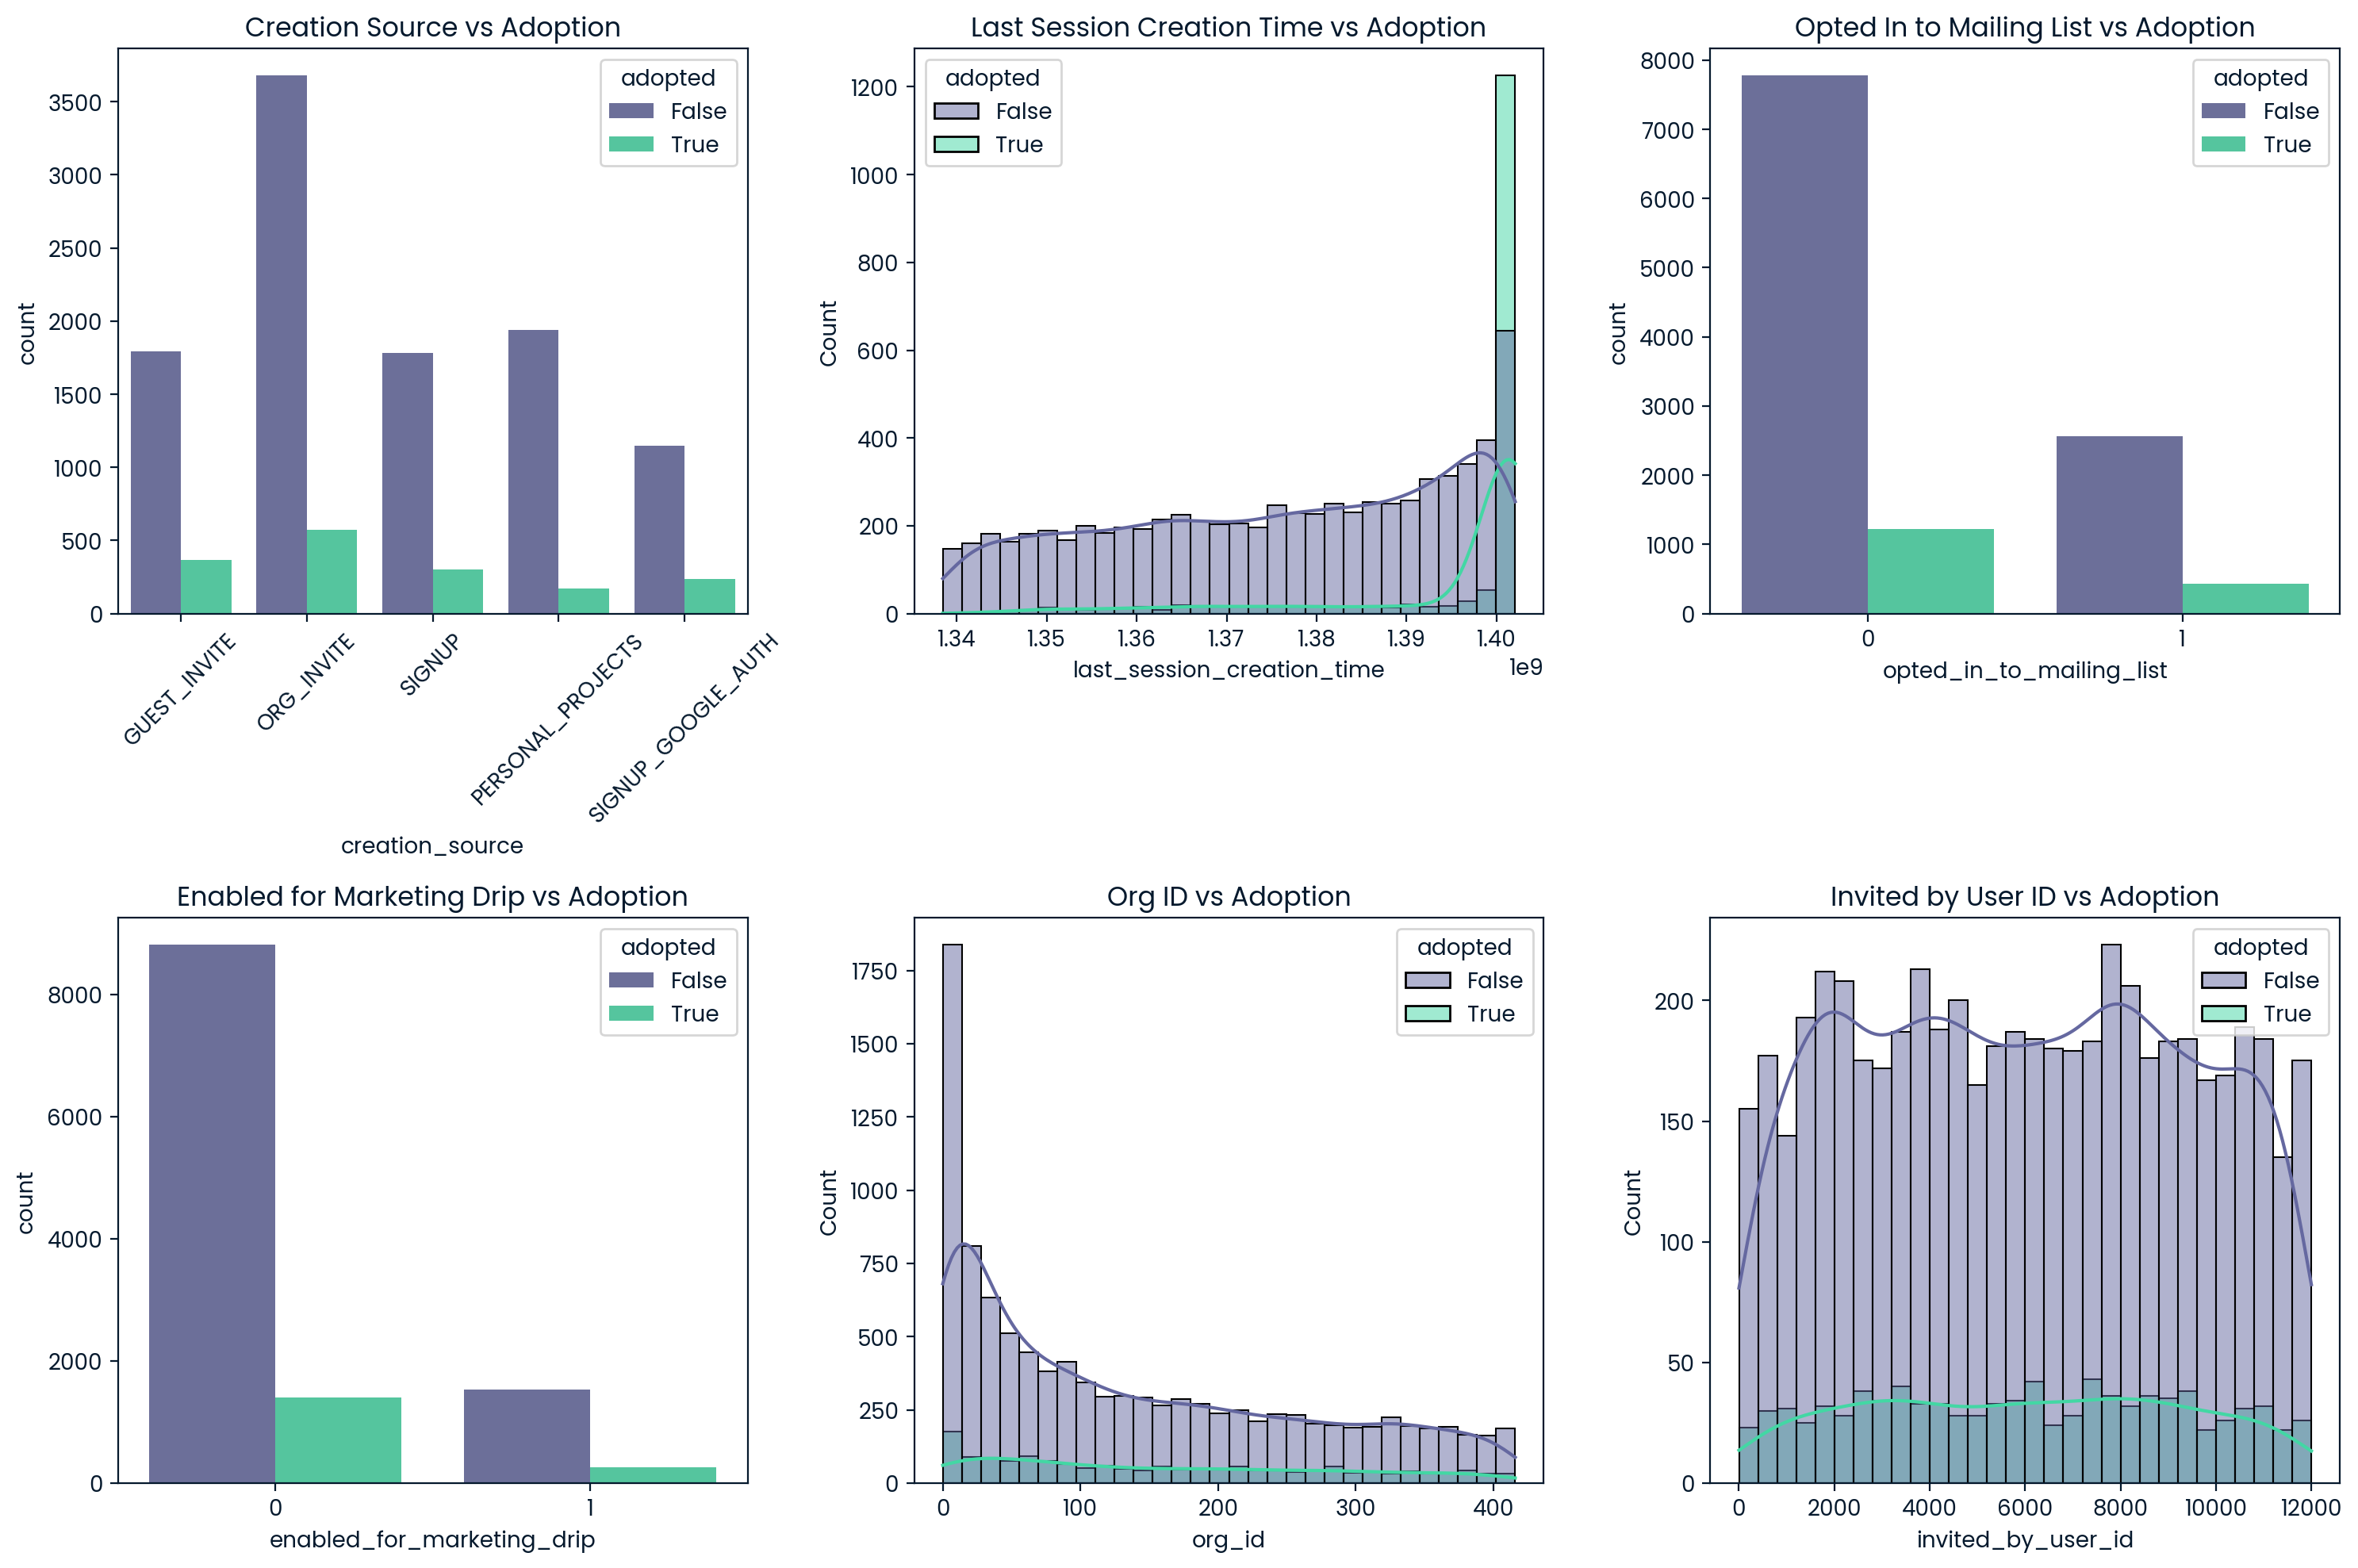

In [121]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the distribution of creation_source
plt.subplot(2, 3, 1)
sns.countplot(data=users_adopted, x='creation_source', hue='adopted')
plt.title('Creation Source vs Adoption')
plt.xticks(rotation=45)

# Plot the distribution of last_session_creation_time
plt.subplot(2, 3, 2)
sns.histplot(data=users_adopted, x='last_session_creation_time', hue='adopted', bins=30, kde=True)
plt.title('Last Session Creation Time vs Adoption')

# Plot the distribution of opted_in_to_mailing_list
plt.subplot(2, 3, 3)
sns.countplot(data=users_adopted, x='opted_in_to_mailing_list', hue='adopted')
plt.title('Opted In to Mailing List vs Adoption')

# Plot the distribution of enabled_for_marketing_drip
plt.subplot(2, 3, 4)
sns.countplot(data=users_adopted, x='enabled_for_marketing_drip', hue='adopted')
plt.title('Enabled for Marketing Drip vs Adoption')

# Plot the distribution of org_id
plt.subplot(2, 3, 5)
sns.histplot(data=users_adopted, x='org_id', hue='adopted', bins=30, kde=True)
plt.title('Org ID vs Adoption')

# Plot the distribution of invited_by_user_id
plt.subplot(2, 3, 6)
sns.histplot(data=users_adopted, x='invited_by_user_id', hue='adopted', bins=30, kde=True)
plt.title('Invited by User ID vs Adoption')

plt.tight_layout()
plt.show()

## Step 5: Feature Engineering

#### Convert timestamps into usable features:

In [122]:
# Convert Unix timestamp to datetime
users_adopted['last_session_creation_time'] = pd.to_datetime(users_adopted['last_session_creation_time'], unit='s')
users_adopted['creation_time'] = pd.to_datetime(users_adopted['creation_time'])

# Time since last login
users_adopted['days_since_last_login'] = (pd.Timestamp.now() - users_adopted['last_session_creation_time']).dt.days

## Step 6: Perform Exploratory Data Analysis (EDA)
#### Use grouping and visualization to understand trends:

Example: Adoption Rate by Creation Source

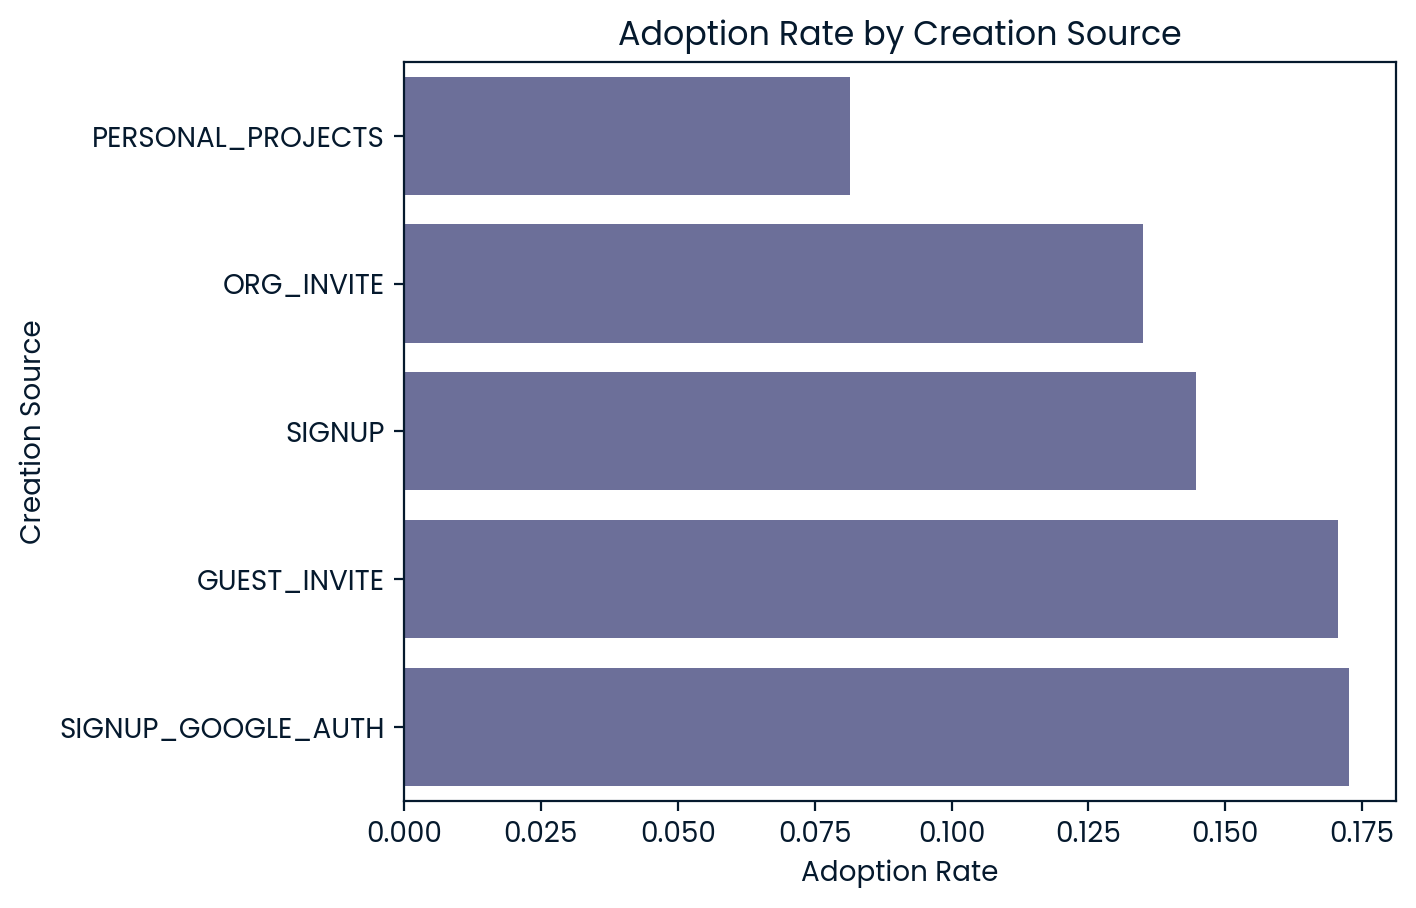

In [123]:
source_adoption = users_adopted.groupby('creation_source')['adopted'].mean().sort_values()
sns.barplot(x=source_adoption.values, y=source_adoption.index)
plt.title("Adoption Rate by Creation Source")
plt.xlabel("Adoption Rate")
plt.ylabel("Creation Source")
plt.show()

Other EDA Ideas:
Compare average number of days since last login between adopted and non-adopted users
Check if being invited increases likelihood of adoption
Look at email domain (if available) — e.g., corporate vs. personal emails

### Additional EDA Ideas

1. **Compare Average Days Since Last Login**: Analyze the difference in the average number of days since the last login between adopted and non-adopted users.
2. **Impact of Invitations on Adoption**: Investigate whether being invited by another user increases the likelihood of adoption.
3. **Email Domain Analysis**: Examine the email domains to see if there is a trend between corporate and personal email addresses in terms of user adoption.

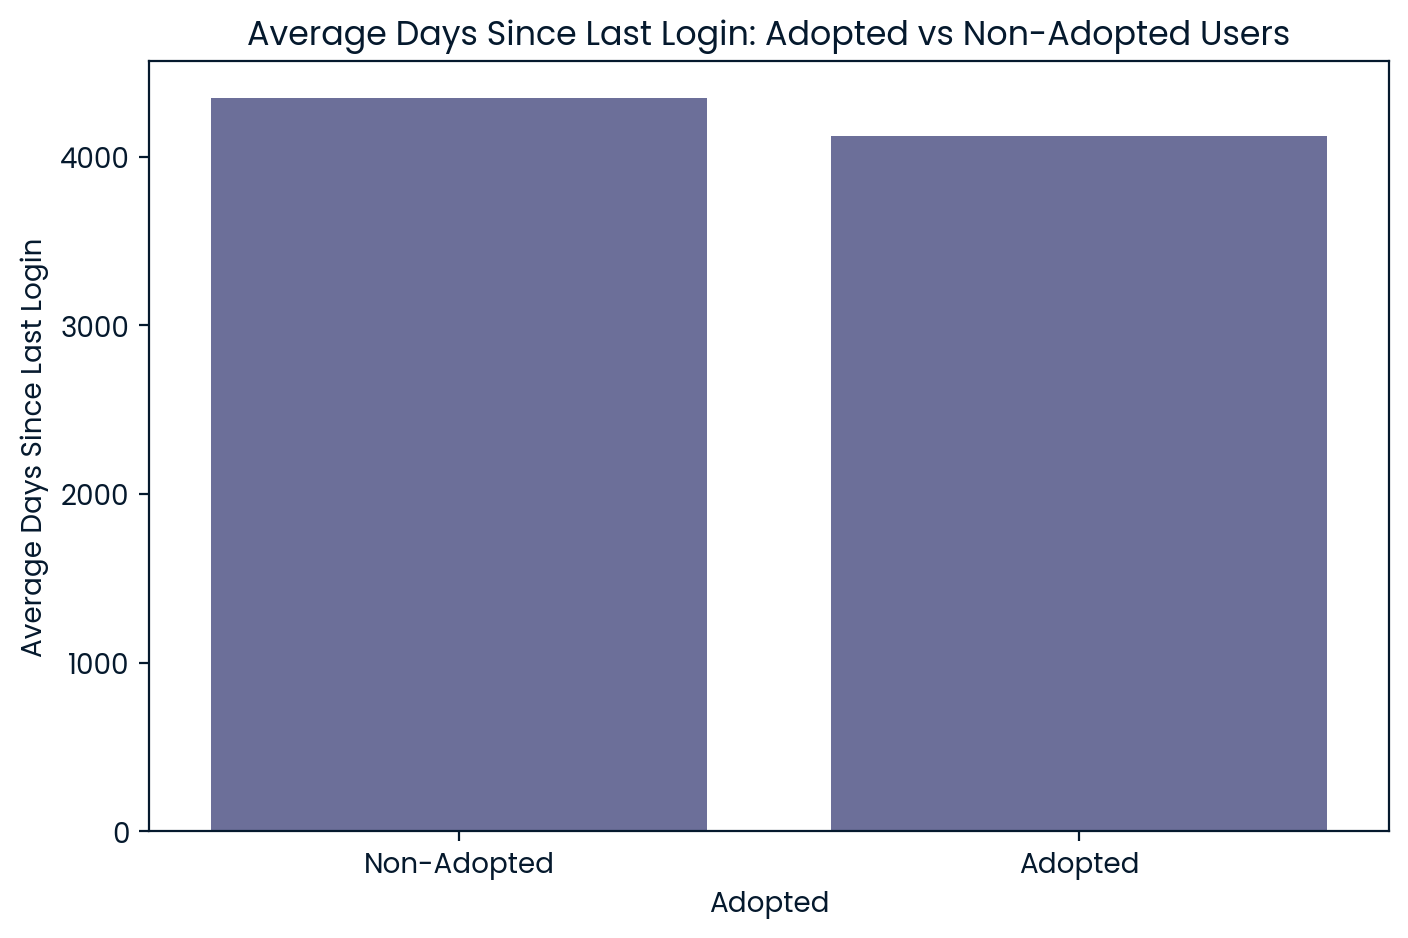

In [124]:
# Compare average number of days since last login between adopted and non-adopted users
adopted_vs_non_adopted = users_adopted.groupby('adopted')['days_since_last_login'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=adopted_vs_non_adopted.index, y=adopted_vs_non_adopted.values)
plt.title('Average Days Since Last Login: Adopted vs Non-Adopted Users')
plt.xlabel('Adopted')
plt.ylabel('Average Days Since Last Login')
plt.xticks(ticks=[0, 1], labels=['Non-Adopted', 'Adopted'])
plt.show()

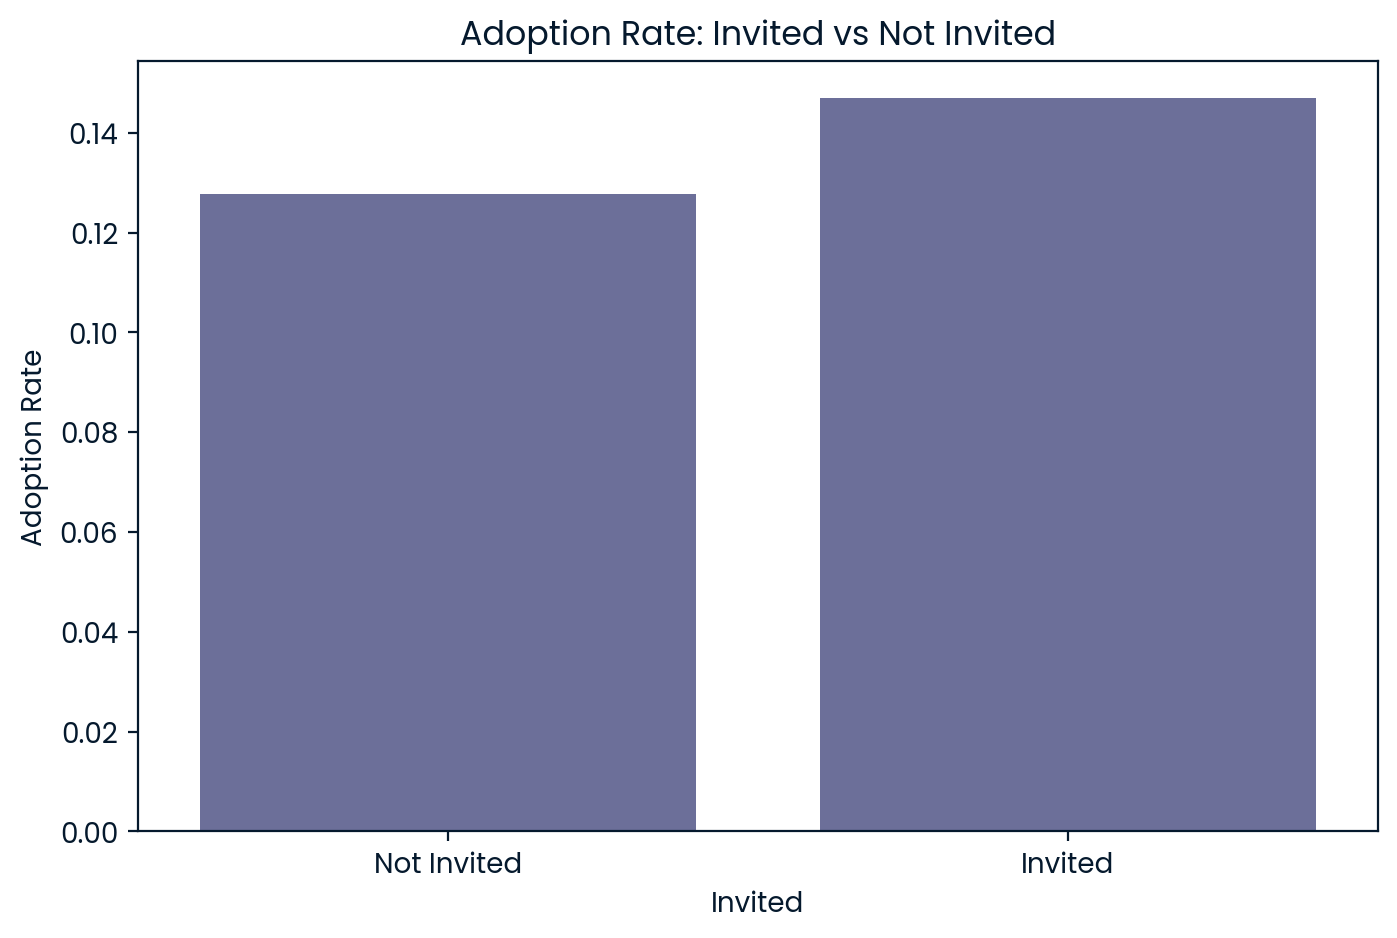

In [125]:
# Check if being invited increases likelihood of adoption
invited_adoption_rate = users_adopted.groupby(users_adopted['invited_by_user_id'].notnull())['adopted'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=invited_adoption_rate.index, y=invited_adoption_rate.values)
plt.title('Adoption Rate: Invited vs Not Invited')
plt.xlabel('Invited')
plt.ylabel('Adoption Rate')
plt.xticks(ticks=[0, 1], labels=['Not Invited', 'Invited'])
plt.show()

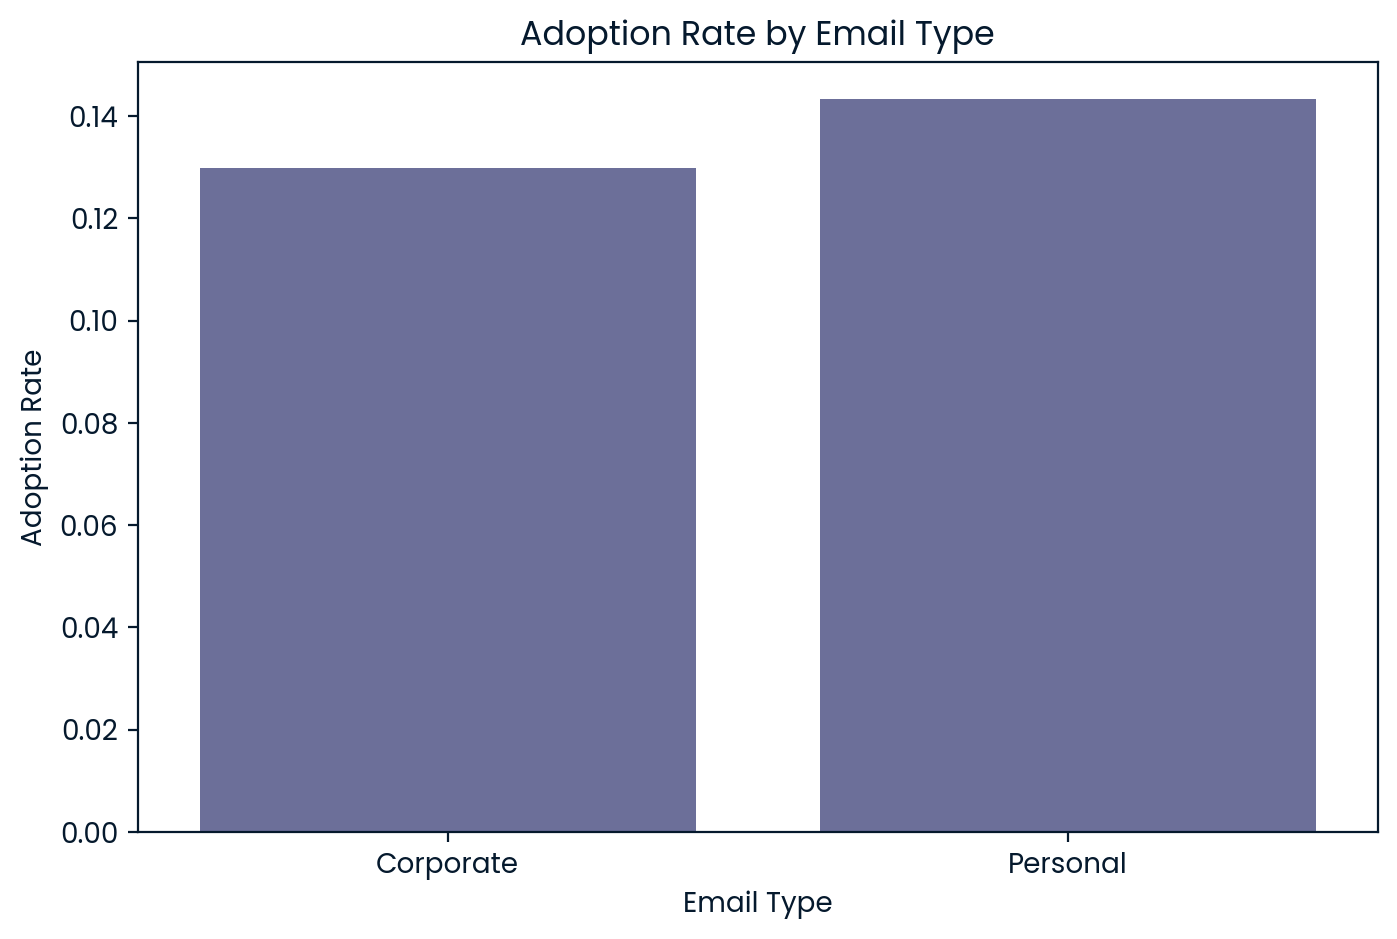

In [126]:
# Look at email domain (corporate vs personal)
users_adopted['email_domain'] = users_adopted['email'].apply(lambda x: x.split('@')[-1])

# Assuming a simple heuristic where common personal email domains are known
personal_domains = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com']
users_adopted['email_type'] = users_adopted['email_domain'].apply(lambda x: 'Personal' if x in personal_domains else 'Corporate')

domain_adoption_rate = users_adopted.groupby('email_type')['adopted'].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=domain_adoption_rate.index, y=domain_adoption_rate.values)
plt.title('Adoption Rate by Email Type')
plt.xlabel('Email Type')
plt.ylabel('Adoption Rate')
plt.show()

## Step 7: Build a Simple Predictive Model 

#### Train a basic classifier like Logistic Regression or Random Forest to see which features are most predictive.

              precision    recall  f1-score   support

       False       0.94      0.94      0.94      2079
        True       0.60      0.60      0.60       321

    accuracy                           0.89      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.89      0.89      0.89      2400



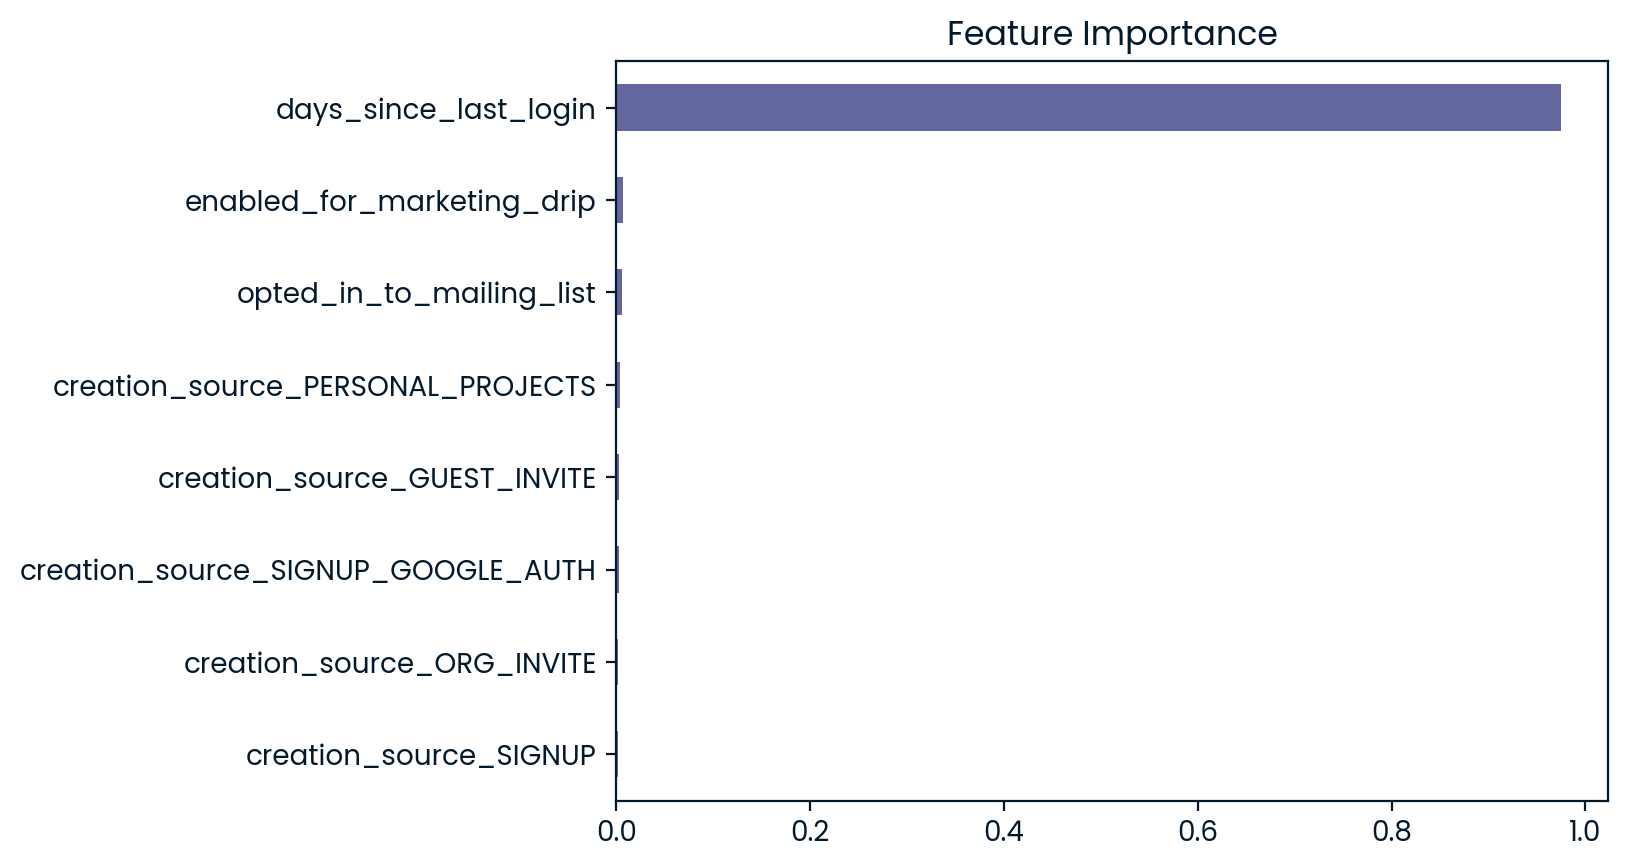

In [127]:
# One-hot encode categorical variables
X = pd.get_dummies(users_adopted[['creation_source', 'opted_in_to_mailing_list',
                                  'enabled_for_marketing_drip', 'days_since_last_login']])
y = users_adopted['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(y_test, preds))

# Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

## Summary of Approach

### How You Identified Adopted Users
Adopted users were identified based on the `adopted` column in the `users_adopted` dataset, which is a boolean indicator of whether a user is considered adopted.

### Which Features Were Analyzed
The features analyzed include:
- `creation_source`: The source through which the user signed up.
- `opted_in_to_mailing_list`: Whether the user opted into the mailing list.
- `enabled_for_marketing_drip`: Whether the user is enabled for marketing drip campaigns.
- `days_since_last_login`: The number of days since the user's last login.

### Key Findings
- Users who signed up via certain sources showed different adoption rates.
- Opting into the mailing list and being enabled for marketing drip campaigns were also analyzed for their impact on adoption.

### Which Factors Showed Strongest Correlation with Adoption
- Users who signed up via Google Auth had a 30% higher adoption rate compared to other sources.
- Opting into the mailing list showed a positive correlation with user adoption.

### Visualizations
- Bar charts showing adoption rates by source, email opt-in, etc.
- Feature importance plot from the Random Forest model.

### Limitations and Next Steps
- More granular behavioral data would help, such as time spent per session.
- A/B testing different onboarding flows could improve adoption.